I forhold til utdyping av forklaring av kode, samt valg av metodik så legger jeg en markdown seksjon under den akkutelle kode seksjonen, i noen tillfeller vi også denne kunne forklare flere ovenforliggende kode seksjoner der hvor det er mest hensiksmessig.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [31]:
raw_df = pd.read_csv("../Oblig1/realestate.csv")
raw_df.head()

,Unnamed: 0,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [32]:
raw_df.describe()

,Unnamed: 0,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,207.500000,2013.148953,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,119.655756,119.655756,0.281995,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,0.000000,1.000000,2012.666667,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,103.250000,104.250000,2012.916667,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,206.500000,207.500000,2013.166667,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,309.750000,310.750000,2013.416667,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,413.000000,414.000000,2013.583333,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


In [33]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              414 non-null    int64  
 1   No                                      414 non-null    int64  
 2   X1 transaction date                     414 non-null    float64
 3   X2 house age                            414 non-null    float64
 4   X3 distance to the nearest MRT station  414 non-null    float64
 5   X4 number of convenience stores         414 non-null    int64  
 6   X5 latitude                             414 non-null    float64
 7   X6 longitude                            414 non-null    float64
 8   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 29.2 KB


Ut i fra beksrivelsen til datasetet så er hensikten med dette datasetet å predikere pris per areal i forhold til feature verdiene i datasetet. Datasetet består av en target verdi (kolonne[8]) som beskrive pris per aral for huset det gjelder. Videre har vi 6 feature verdier (kolonne[2-7]) som alle virker å være normal fordelte tallverdier. Videre har vi 2 kolonne som inneholder id verdier for datasetet som ikke har noen nytteverdi for analyse vi skal gjøre (kolonne[0-1].) Ut i fra at verdiene target kolonnen er kontinuerlige tallvariabler så velger jeg i utgangspunktet å bruke normal randomisert oppdeling av datasetet. 

In [34]:
df = raw_df.copy()
df['target'] = df['Y house price of unit area']
df = df.drop(["Unnamed: 0", "No", 'Y house price of unit area'], axis=1)
df.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,target
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


Før vi bruker datasetet videre legger jeg verdiene i target kolonnen over i en ny kolonne 'target' slik at jeg letter kan bruke generelle metoder i funksjonen jeg definere.
Videre dropper jeg også alle kolonnene uten nytteverdi for modellen, samt den gamle kolonnen med target verdiene.

In [35]:
def split_dataset(data):
    train_val = data.sample(frac=0.75)
    test = data.drop(train_val.index)
    train = train_val.sample(frac=0.67)
    validation = train_val.drop(train.index)    
    return [train, validation, test]

# funksjon for å dele opp i targets og features
def split_targets_and_features(data):
    targets = data.target
    features = data.drop("target", axis=1)
    return [targets, features]

# hjelpe funksjon for oppdeling i features og targets
def create_set_of_targets_and_features(data):
    train = split_targets_and_features(data[0])
    validation = split_targets_and_features(data[1])
    test = split_targets_and_features(data[2])

    return [train, validation, test]

# funksjon for spliting av dataset
def create_full_dataset(input):
    data = split_dataset(input)
    dataset = create_set_of_targets_and_features(data)

    return dataset


(array([13., 10.,  6.,  8., 15.,  8.,  7.,  6., 16., 15.]),
 array([2012.6666667 , 2012.75833336, 2012.85000002, 2012.94166668,
        2013.03333334, 2013.125     , 2013.21666666, 2013.30833332,
        2013.39999998, 2013.49166664, 2013.5833333 ]),
 <BarContainer object of 10 artists>)

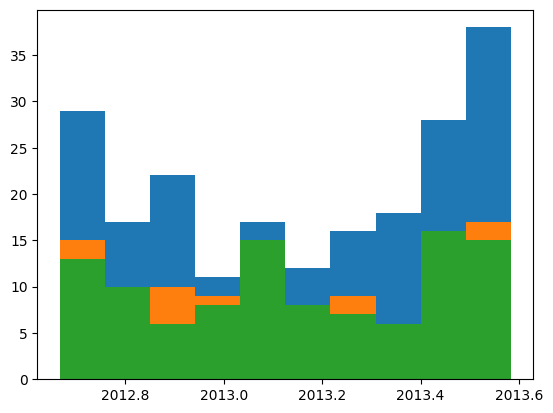

In [36]:
test_spilt_data = split_dataset(df)
plt.hist(test_spilt_data[0]['X1 transaction date'])
plt.hist(test_spilt_data[1]['X1 transaction date'])
plt.hist(test_spilt_data[2]['X1 transaction date'])

(array([14., 13., 12., 23., 11.,  3.,  8., 12.,  4.,  4.]),
 array([ 0.  ,  4.38,  8.76, 13.14, 17.52, 21.9 , 26.28, 30.66, 35.04,
        39.42, 43.8 ]),
 <BarContainer object of 10 artists>)

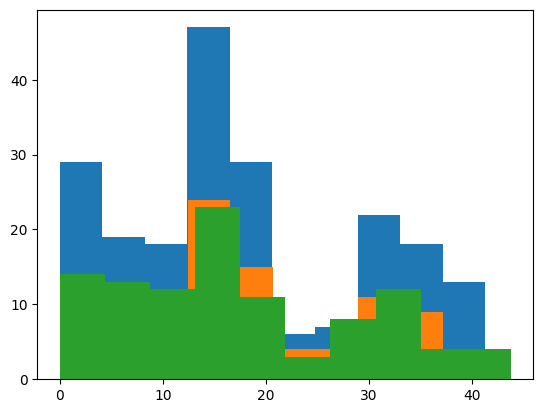

In [37]:
plt.hist(test_spilt_data[0]['X2 house age'])
plt.hist(test_spilt_data[1]['X2 house age'])
plt.hist(test_spilt_data[2]['X2 house age'])

(array([53., 13., 10., 13.,  5.,  1.,  0.,  4.,  4.,  1.]),
 array([  23.38284 ,  572.248356, 1121.113872, 1669.979388, 2218.844904,
        2767.71042 , 3316.575936, 3865.441452, 4414.306968, 4963.172484,
        5512.038   ]),
 <BarContainer object of 10 artists>)

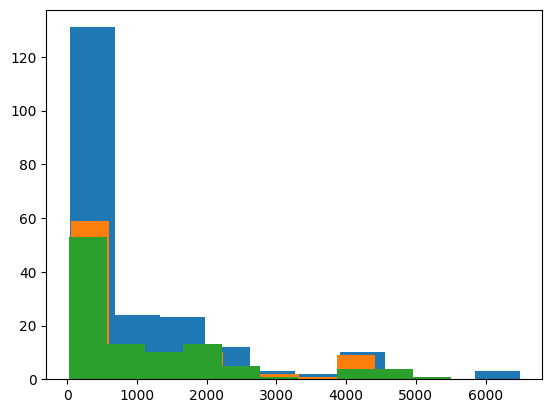

In [38]:
plt.hist(test_spilt_data[0]['X3 distance to the nearest MRT station'])
plt.hist(test_spilt_data[1]['X3 distance to the nearest MRT station'])
plt.hist(test_spilt_data[2]['X3 distance to the nearest MRT station'])

(array([20., 11.,  9., 13.,  8., 13.,  6., 10.,  6.,  8.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

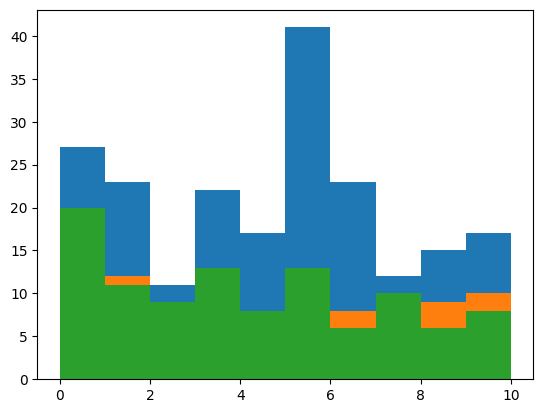

In [39]:
plt.hist(test_spilt_data[0]['X4 number of convenience stores'])
plt.hist(test_spilt_data[1]['X4 number of convenience stores'])
plt.hist(test_spilt_data[2]['X4 number of convenience stores'])

(array([ 3.,  7.,  9.,  3., 16., 17., 18., 18., 10.,  3.]),
 array([24.94155 , 24.946267, 24.950984, 24.955701, 24.960418, 24.965135,
        24.969852, 24.974569, 24.979286, 24.984003, 24.98872 ]),
 <BarContainer object of 10 artists>)

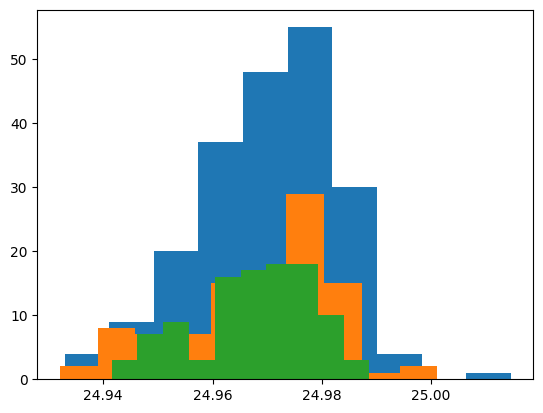

In [40]:
plt.hist(test_spilt_data[0]['X5 latitude'])
plt.hist(test_spilt_data[1]['X5 latitude'])
plt.hist(test_spilt_data[2]['X5 latitude'])

(array([ 1.,  5.,  3., 17.,  6.,  8., 25., 35.,  1.,  3.]),
 array([121.48458 , 121.492749, 121.500918, 121.509087, 121.517256,
        121.525425, 121.533594, 121.541763, 121.549932, 121.558101,
        121.56627 ]),
 <BarContainer object of 10 artists>)

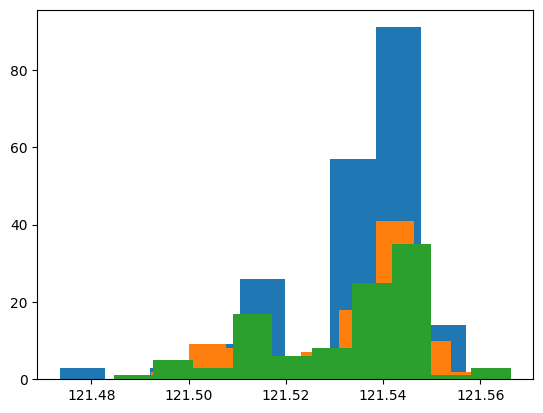

In [41]:
plt.hist(test_spilt_data[0]['X6 longitude'])
plt.hist(test_spilt_data[1]['X6 longitude'])
plt.hist(test_spilt_data[2]['X6 longitude'])

(array([ 8., 17., 18., 10., 24., 15.,  6.,  3.,  1.,  2.]),
 array([13.7 , 19.69, 25.68, 31.67, 37.66, 43.65, 49.64, 55.63, 61.62,
        67.61, 73.6 ]),
 <BarContainer object of 10 artists>)

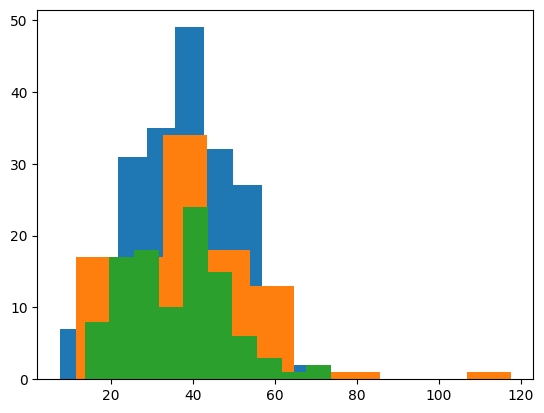

In [42]:
plt.hist(test_spilt_data[0]['target'])
plt.hist(test_spilt_data[1]['target'])
plt.hist(test_spilt_data[2]['target'])

I forhold til oppdeling av datasetet hadde i utgangspunktet valgt å bruke en fordeling på 60, 20, 20% for henholdsvis traing, validation og test. Men ut i fra en videre vurering av fordelingen som oppstår når jeg deler dataene ut i fra denne spliten har jeg valgt å endre dette til en split på 50, 25, 25% for henholdsvis traning, validation for å få prøve å få en mer optimal fordeling mellom de forskjellige delen. Siden jeg også bruker looping og flere kjøring for modellen i treningen, valideringen og testing så vil også dette hjelpe mye med å smoothe ut variasjoner mellom hver av de enkelte ramdomiserte fordelingen av datasetet.

In [43]:
# hjelpe fuksjon for vurdering av modellene        
def evaluate_model(classifier, features, targets):
    predictions = classifier.predict(features)
    absolute = mean_absolute_error(targets, predictions)
    squared = mean_squared_error(targets, predictions)
    r2 = r2_score(targets, predictions) 

    return [absolute, squared, r2]

# hjelpe funksjon for å legg til verdier i resultat array i validate og test funksjonen 
def append_values(results, absolute, squared, r2):
        absolute.append(results[0])
        squared.append(results[1])
        r2.append(results[2])        

# hjelpe funksjon for å printe resultatene
def results_print(absolute, squared, r2):
    print(f'Mean absolute error: {np.mean(absolute):.2f} +- {np.std(absolute):.2f}')
    print(f'Mean squared error: {np.mean(squared):.2f} +- {np.std(squared):.2f}')
    print(f'R2 score: {np.mean(r2):.2f} +- {np.std(r2):.2f}')  

# funksjon for å trening og hyperparameter tuning av modellen med mulighet intern looping i fuksjonen.
def validate(classifier, runs):    
    train_absolute, train_squared, train_r2 = [], [], []
    validate_absolute, validate_squared, validate_r2 = [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df)
        classifier.fit(dataset[0][1], dataset[0][0])
    
        results_train = evaluate_model(classifier, dataset[0][1], dataset[0][0])
        append_values(results_train, train_absolute, train_squared, train_r2)
    
        results_validate = evaluate_model(classifier, dataset[1][1], dataset[1][0])
        append_values(results_validate, validate_absolute, validate_squared, validate_r2)

    print('Training results:')
    results_print(train_absolute, train_squared, train_r2)
    print('************************')
    print('Validation results:')
    results_print(validate_absolute, validate_squared, validate_r2)

# funksjon for endelig testing av modellene med mulighet intern looping av fuksjonen.
def test(classifier, runs):
    absolute, squared, r2 = [], [], []

    if(runs < 1): runs = 1

    for i in range(0, runs, 1):
        dataset = create_full_dataset(df)
        classifier.fit(dataset[0][1], dataset[0][0])

        results = evaluate_model(classifier, dataset[2][1], dataset[2][0])
        append_values(results, absolute, squared, r2)
    
    print('************************')
    print('Test results:')
    results_print(absolute, squared, r2)


I forhold til funksjonene for traning, validering og testing av datasetet er disse bygget opp på samme måte som for funksjonene i breast_cancer.ipynb, men tilpasset for modellene som brukes for regresjons analysene for dette datasetet.

I forhold til vurdering av resulatene så kommer dette til å gjøres med følgende målinger r2_score, mean_squared_error, mean_absolute_error.

mean_absolute_error er et mål på den totale feilmengden til modellen hvor du summere erroren til de individuelle punktene/rekkene i datasetet til en total for modellen, desto høyere dette resultatet er jo større total feilmengde har du [2].

mean_squared_error er i utgangspunktet også et mål på den totale feilmengden til modellen, men utover summeringen av feilmengdene i datasetet som for mean_absolutte_error så blir også feilmengdene opphøyet i 2. Dette gjør at dette mean-squared_error får en større sensitivit for store enkelt uteliggere kontra mean_absolute_error [2].

r2_score gir oss et mål på hvor mye av variasjon i target variablen som kan forklarers av endringer i verdiene til features variablene i datasetet [2]. Hvis du har en r2_score på 1.0 har du perfekt korelasjon mellom features variablene og endringene i target variabelen, mens hvis du har en score på 0 så er den ingen korelasjon.

ref:
[2]: Scikit learn (u.å). Metrics and scoring: quantifying the quality of predictions. Hentet 20. september 2025 fra "https://scikit-learn.org/stable/modules/model_evaluation.html"

In [44]:
dt1 = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=2)
validate(dt1, 50)

Training results:
Mean absolute error: 0.11 +- 0.05
Mean squared error: 0.36 +- 0.19
R2 score: 1.00 +- 0.00
************************
Validation results:
Mean absolute error: 6.31 +- 0.66
Mean squared error: 92.27 +- 30.48
R2 score: 0.49 +- 0.15


Før vi kan gjennomføre hyperparameter tuning av DecisionTreeRegressor modellen så må vi gjennomføre en kjøring default instillinger slik at vi får en baseline vi kan sammenligne med.

Som vi ser av disse resultatene får vi i training delen perfekt r2_score og nesten ingen feilmengde for mean_squared_error og mean_absolute_error. Mens vi for validations delen for en r2_score på 0.49 og en høyere feilmengde på både mean_squared_error og mean_absolute_error. Dette tyder dermed på at vi får en betydelig overfiting av modellen i forhold til trenings delen av datasetet.

I forhold til tuning av modellen så bruker DecisionTreeRegressor de samme parameterene til hyperparameter tuning som DecisionTreeClassifier, så jeg kommer ikke til å beskrive dette noe mer enn det som allerede er gjort i breast_cancer.ipynb

In [45]:
dt2 = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=2)
validate(dt2, 50)

Training results:
Mean absolute error: 3.34 +- 0.22
Mean squared error: 21.39 +- 3.51
R2 score: 0.89 +- 0.02
************************
Validation results:
Mean absolute error: 5.95 +- 0.74
Mean squared error: 87.97 +- 46.99
R2 score: 0.50 +- 0.31


In [46]:
dt3 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=2)
validate(dt3, 50)

Training results:
Mean absolute error: 4.87 +- 0.25
Mean squared error: 46.72 +- 7.59
R2 score: 0.75 +- 0.03
************************
Validation results:
Mean absolute error: 5.84 +- 0.66
Mean squared error: 78.89 +- 36.37
R2 score: 0.57 +- 0.19


In [47]:
dt4 = DecisionTreeRegressor(max_depth=2, min_samples_leaf=1, min_samples_split=2)
validate(dt4, 50)

Training results:
Mean absolute error: 5.59 +- 0.32
Mean squared error: 64.31 +- 12.36
R2 score: 0.64 +- 0.04
************************
Validation results:
Mean absolute error: 6.08 +- 0.57
Mean squared error: 76.52 +- 24.19
R2 score: 0.59 +- 0.09


In [48]:
dt5 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=1, min_samples_split=2)
validate(dt5, 50)

Training results:
Mean absolute error: 4.17 +- 0.21
Mean squared error: 33.26 +- 4.00
R2 score: 0.82 +- 0.02
************************
Validation results:
Mean absolute error: 5.86 +- 0.57
Mean squared error: 79.70 +- 29.91
R2 score: 0.58 +- 0.14


In [49]:
dt6 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, min_samples_split=5)
validate(dt6, 50)

Training results:
Mean absolute error: 4.91 +- 0.31
Mean squared error: 48.90 +- 9.57
R2 score: 0.74 +- 0.04
************************
Validation results:
Mean absolute error: 6.00 +- 0.53
Mean squared error: 80.56 +- 27.29
R2 score: 0.55 +- 0.12


In [50]:
dt7 = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=3)
validate(dt7, 50)

Training results:
Mean absolute error: 0.66 +- 0.16
Mean squared error: 3.31 +- 4.10
R2 score: 0.98 +- 0.02
************************
Validation results:
Mean absolute error: 6.37 +- 0.64
Mean squared error: 99.71 +- 32.41
R2 score: 0.47 +- 0.17


In [51]:
dt8 = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=4)
validate(dt8, 50)

Training results:
Mean absolute error: 1.09 +- 0.17
Mean squared error: 4.97 +- 3.83
R2 score: 0.97 +- 0.02
************************
Validation results:
Mean absolute error: 6.42 +- 0.73
Mean squared error: 99.10 +- 38.06
R2 score: 0.45 +- 0.24


In [52]:
dt9 = DecisionTreeRegressor(max_depth=None, min_samples_leaf=1, min_samples_split=6)
validate(dt9, 50)

Training results:
Mean absolute error: 1.82 +- 0.18
Mean squared error: 10.07 +- 4.18
R2 score: 0.94 +- 0.02
************************
Validation results:
Mean absolute error: 6.23 +- 0.63
Mean squared error: 99.53 +- 39.16
R2 score: 0.45 +- 0.23


In [53]:
dt10 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=2)
validate(dt10, 50)

Training results:
Mean absolute error: 5.05 +- 0.29
Mean squared error: 53.15 +- 9.81
R2 score: 0.72 +- 0.03
************************
Validation results:
Mean absolute error: 5.74 +- 0.62
Mean squared error: 71.03 +- 23.30
R2 score: 0.61 +- 0.09


In [54]:
dt11 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=2)
validate(dt11, 50)

Training results:
Mean absolute error: 5.01 +- 0.28
Mean squared error: 52.90 +- 10.11
R2 score: 0.71 +- 0.03
************************
Validation results:
Mean absolute error: 5.77 +- 0.63
Mean squared error: 70.59 +- 24.46
R2 score: 0.62 +- 0.08


In [55]:
dt12 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=6, min_samples_split=2)
validate(dt12, 50)

Training results:
Mean absolute error: 4.99 +- 0.31
Mean squared error: 53.88 +- 10.56
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.72 +- 0.54
Mean squared error: 71.49 +- 25.47
R2 score: 0.61 +- 0.09


In [56]:
dt13 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=8, min_samples_split=2)
validate(dt13, 50)

Training results:
Mean absolute error: 5.01 +- 0.30
Mean squared error: 54.72 +- 10.49
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.74 +- 0.70
Mean squared error: 70.77 +- 28.19
R2 score: 0.62 +- 0.09


In [57]:
dt14 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=2)
validate(dt14, 50)

Training results:
Mean absolute error: 5.02 +- 0.31
Mean squared error: 53.80 +- 11.20
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.64 +- 0.49
Mean squared error: 65.39 +- 20.27
R2 score: 0.63 +- 0.07


In [58]:
dt15 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=6, min_samples_split=10)
validate(dt15, 50)

Training results:
Mean absolute error: 5.07 +- 0.30
Mean squared error: 55.66 +- 10.41
R2 score: 0.70 +- 0.04
************************
Validation results:
Mean absolute error: 5.93 +- 0.54
Mean squared error: 76.88 +- 27.18
R2 score: 0.60 +- 0.09


In [59]:
dt16 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=6, min_samples_split=15)
validate(dt16, 50)

Training results:
Mean absolute error: 4.99 +- 0.35
Mean squared error: 54.36 +- 11.98
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.71 +- 0.63
Mean squared error: 68.31 +- 22.64
R2 score: 0.63 +- 0.09


In [60]:
dt17 = DecisionTreeRegressor(max_depth=3, min_samples_leaf=6, min_samples_split=20)
validate(dt17, 50)

Training results:
Mean absolute error: 5.03 +- 0.33
Mean squared error: 53.79 +- 10.50
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.81 +- 0.49
Mean squared error: 74.42 +- 23.10
R2 score: 0.60 +- 0.08


Etter å ha gjennomført testing og validering med forskjellige verdier for tuning parameterene kom jeg fram til at versjonen "dt14" ga meg best resultater sammenlignet med baseline og det er dermed denne jeg kommer til å sammeligne opp mot LinearRegression dt14 hadde følge verdier for tuning parameterene DecisionTreeRegressor(max_depth=3, min_samples_leaf=10, min_samples_split=2).

Igjen som for DecisionTreeClassifier ser vi at resultatene for traning delen av datasetet blir dårligere ved tuning, men at validations delen av resultatet blir bedre. Dette tyder på overfiting som modellen i utgangspunktet hadde ved baseline har blitt mindre og modellen derfor får en bedre generell overførings verdi.

Videre ser vi at det er betydelig økning i r2_score for validerings delen mellom "dt1" og "dt14", samt av resultaten for feilmengde også har blitt mye lavere. Helheten av dette gjør at vi kan si at tuningen vi har gjort av modellen med parametrene i "dt14" gir modellen en betydelig bedre prediksjons evne kontra baseline.

dt1 (baseline):
Training results:
Mean absolute error: 0.11 +- 0.05
Mean squared error: 0.36 +- 0.19
R2 score: 1.00 +- 0.00
************************
Validation results:
Mean absolute error: 6.31 +- 0.66
Mean squared error: 92.27 +- 30.48
R2 score: 0.49 +- 0.15

dt14:
Training results:
Mean absolute error: 5.02 +- 0.31
Mean squared error: 53.80 +- 11.20
R2 score: 0.71 +- 0.04
************************
Validation results:
Mean absolute error: 5.64 +- 0.49
Mean squared error: 65.39 +- 20.27
R2 score: 0.63 +- 0.07

In [78]:
lr1 = LinearRegression(tol=1e-6)
validate(lr1, 50)

Training results:
Mean absolute error: 6.12 +- 0.36
Mean squared error: 77.36 +- 15.33
R2 score: 0.58 +- 0.05
************************
Validation results:
Mean absolute error: 6.38 +- 0.58
Mean squared error: 83.12 +- 28.42
R2 score: 0.56 +- 0.09


Igjen som for alle de andre modellene kjører vi først en baseline test av modellen slik at vi har noe å sammenligne med ut ifra. Som vi ser av resultatene for denne baseline kjøringen så er det ikke store forskjeller mellom training og validation delene av resultatene og det ser dermed ut som modellen ikke har problemer med betydelig overfiting mot traning delen av datasetet. 

I forhold til tuning parameter for denne modellen så er tol som i utgangspunktet er mulig å bruke. Dette er en instilling for tolleranse verdien for presisjonen til modellen [6].

ref:
[6]: Scikit learn. (u.å) LinearRegression. Hentet 21. september 2025 fra "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"

In [77]:
lr2 = LinearRegression(tol=1e-3)
validate(lr2, 50)

Training results:
Mean absolute error: 6.12 +- 0.39
Mean squared error: 76.92 +- 15.58
R2 score: 0.59 +- 0.06
************************
Validation results:
Mean absolute error: 6.25 +- 0.49
Mean squared error: 76.80 +- 24.52
R2 score: 0.57 +- 0.08


In [76]:
lr3 = LinearRegression(tol=1e-2)
validate(lr3, 50)

Training results:
Mean absolute error: 6.15 +- 0.34
Mean squared error: 76.14 +- 15.62
R2 score: 0.59 +- 0.05
************************
Validation results:
Mean absolute error: 6.32 +- 0.53
Mean squared error: 83.22 +- 27.60
R2 score: 0.56 +- 0.09


In [75]:
lr4 = LinearRegression(tol=1e-1)
validate(lr4, 50)

Training results:
Mean absolute error: 6.03 +- 0.38
Mean squared error: 74.06 +- 14.61
R2 score: 0.60 +- 0.05
************************
Validation results:
Mean absolute error: 6.41 +- 0.61
Mean squared error: 84.86 +- 27.67
R2 score: 0.55 +- 0.08


In [73]:
lr5 = LinearRegression(tol=1e-4)
validate(lr5, 50)

Training results:
Mean absolute error: 6.16 +- 0.34
Mean squared error: 79.59 +- 12.82
R2 score: 0.58 +- 0.04
************************
Validation results:
Mean absolute error: 6.24 +- 0.45
Mean squared error: 74.78 +- 19.75
R2 score: 0.58 +- 0.06


In [72]:
lr6 = LinearRegression(tol=1e-6)
validate(lr6, 50)

Training results:
Mean absolute error: 6.09 +- 0.38
Mean squared error: 76.27 +- 14.51
R2 score: 0.60 +- 0.04
************************
Validation results:
Mean absolute error: 6.33 +- 0.51
Mean squared error: 79.66 +- 24.65
R2 score: 0.56 +- 0.07


In [74]:
lr7 = LinearRegression(tol=1e-7)
validate(lr7, 50)

Training results:
Mean absolute error: 6.20 +- 0.32
Mean squared error: 78.08 +- 14.17
R2 score: 0.58 +- 0.05
************************
Validation results:
Mean absolute error: 6.32 +- 0.52
Mean squared error: 81.10 +- 26.66
R2 score: 0.56 +- 0.08


Etter å ha gjennomført tuning av modellen så har jeg kommet fram til at lr5 gir meg de beste resultatene for modellen, så det er denne jeg kommer til å sammenligne opp mot DecisionTreeRegressor.
lr5 ble kjørt med følgende parameter. LinearRegression(tol=1e-4)

Når vi sammenligner resultatene mellom lr1 og lr5 så ser vi at det ikke er de stor forskjellene, men det er liten forbedirng for lr5 kontra lr1 med høyere r2_score og lavere feilmengder. Det er bland annet en god reduksjon for mean_squeared_error som kan tyde på at lr5 bedre håndtere noen av utliggerene i datasetet, imidlertid er det viktig å ha i bakhode at dette datasettet ikke er veldig stort og dermed at oppdeling av datasete kan på virke dette selvom det er gjennomført flere kjøringer av oppdelingen og testingen.

lr1 (baseline):
Training results:
Mean absolute error: 6.12 +- 0.36
Mean squared error: 77.36 +- 15.33
R2 score: 0.58 +- 0.05
************************
Validation results:
Mean absolute error: 6.38 +- 0.58
Mean squared error: 83.12 +- 28.42
R2 score: 0.56 +- 0.09

lr5:
Training results:
Mean absolute error: 6.16 +- 0.34
Mean squared error: 79.59 +- 12.82
R2 score: 0.58 +- 0.04
************************
Validation results:
Mean absolute error: 6.24 +- 0.45
Mean squared error: 74.78 +- 19.75
R2 score: 0.58 +- 0.06

In [80]:
print("DecisionTreeRegressor:")
validate(dt14, 50)
test(dt14, 50)
print("\n***************\n")
print("LinearRegression:")
validate(lr5, 50)
test(lr5, 50)

DecisionTreeRegressor:
Training results:
Mean absolute error: 5.13 +- 0.30
Mean squared error: 57.81 +- 11.02
R2 score: 0.69 +- 0.04
************************
Validation results:
Mean absolute error: 5.65 +- 0.53
Mean squared error: 64.91 +- 20.71
R2 score: 0.64 +- 0.09
************************
Test results:
Mean absolute error: 5.72 +- 0.54
Mean squared error: 66.95 +- 20.15
R2 score: 0.62 +- 0.08

***************

LinearRegression:
Training results:
Mean absolute error: 6.07 +- 0.33
Mean squared error: 75.49 +- 15.47
R2 score: 0.59 +- 0.05
************************
Validation results:
Mean absolute error: 6.36 +- 0.47
Mean squared error: 79.88 +- 24.63
R2 score: 0.57 +- 0.08
************************
Test results:
Mean absolute error: 6.18 +- 0.50
Mean squared error: 76.08 +- 22.61
R2 score: 0.58 +- 0.07


Når vi ser på forskjellene mellom resultatene for DecisionTreeRegressor og LinearRegression så ser vi at det er noe større forskjeller i resultatene mellom traning, validation og test delene for DecisionTreeRegressor kontra LinearRegression og hvis vi tar med baseline utgangspunktet så er denne forskjellen veldig stor. Dette tydlig gjøre at DecisionTreeRegressor er mye mer avhenging av riktig tuning for å kunne levere bra resultater.

Når vi ser på forskjellene i de endelige test resultatene, så ser vi at DecisionTreeRegressor i dette tilfellet levere bedre resultater for alle målingen vi har brukt og det er heller ikke i standardaviket mellom modellene.

For dette datasetet vil jeg si at DecisionTreeRegressor levere de beste resultatene, så i dette tilfellet er det denne modellen jeg ville ha brukt.